# 导入库和模块  
`torch.nn`是用来搭建神经网络的  
`torch.optim`是一个用来实现优化算法的库 [官方文档](https://pytorch-cn.readthedocs.io/zh/latest/package_references/torch-optim/)  
`torchvision`包含了目前流行的数据集，模型结构和常用的图片转换工具

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# 定义超参数  
`BATCH_SIZE`是每次送入网络中训练的数据样本的数量  
`EPOCHS`是所有数据经过前向计算和反向传播的次数  
`DEVICE`是判断采用GPU还是CPU的量，为了在不同的机器上得到更好的运行  



In [15]:
BATCH_SIZE = 512
EPOCHS = 20
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
log_interval = 10
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(EPOCHS + 1)]
print(DEVICE)

cuda


# 数据预处理 



In [16]:
train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=True, download=False,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=BATCH_SIZE, shuffle=True)

test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=BATCH_SIZE, shuffle=True)


In [17]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,10,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(10,20,3)
        self.fc1 = nn.Linear(20*10*10,500)
        self.fc2 = nn.Linear(500,10)
        
    def forward(self,x):
        in_size = x.size(0)
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(self.pool(out)))
        out = F.relu(self.fc1(out.view(in_size,-1)))
        out = F.log_softmax(self.fc2(out),dim=1)
        return out
    


In [22]:
model = Net().to(DEVICE)
optimizer = optim.Adam(model.parameters())

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
          train_losses.append(loss.item())
          train_counter.append((batch_idx*512)+((epoch-1)*len(train_loader.dataset)))
                
def test(model, device, test_loader):
    model.eval()
    correct = 0
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.max(1, keepdim=True)[1] 
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Accuracy:{:.2f}%'.format(
        100. * correct / len(test_loader.dataset)))

In [31]:
for epoch in range(1, EPOCHS + 1):
    train(model, DEVICE, train_loader, optimizer, epoch)
    test(model, DEVICE, test_loader)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Accuracy:99.13%

Test set: Accuracy:99.15%

Test set: Accuracy:99.16%

Test set: Accuracy:99.06%

Test set: Accuracy:98.99%

Test set: Accuracy:99.00%

Test set: Accuracy:98.97%

Test set: Accuracy:99.19%

Test set: Accuracy:98.99%

Test set: Accuracy:99.10%

Test set: Accuracy:98.89%

Test set: Accuracy:99.19%

Test set: Accuracy:99.01%

Test set: Accuracy:99.03%

Test set: Accuracy:99.07%

Test set: Accuracy:99.11%

Test set: Accuracy:99.01%

Test set: Accuracy:98.84%

Test set: Accuracy:99.02%

Test set: Accuracy:99.00%


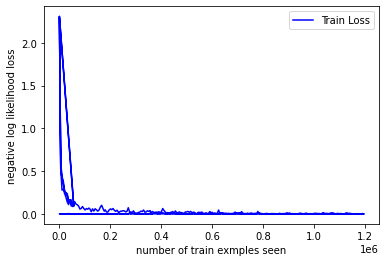

In [32]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(train_counter,train_losses, color='blue')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of train exmples seen')
plt.ylabel('negative log likelihood loss')
plt.show()
